In [ ]:
# Importing library modules
from google.colab import files
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from google.colab.patches import cv2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Add, Dropout, Input
import os
import seaborn as sns

In [ ]:
# Importing data from MyDrive
print(os.listdir("/content/drive/MyDrive/Fire_Color_Map/"))
SIZE = 128
Timages = []
Tlabels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/Fire_Color_Map/*"):
    label = directory_path.split("/")[-1]
    print(label)
    print(directory_path)
    for img_path in glob.glob(os.path.join(directory_path,"*.*")):
      print(img_path)
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
      img = cv2.resize(img, (SIZE, SIZE))
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      Timages.append(img)
      Tlabels.append(label)       
Timages = np.array(Timages)
Tlabels = np.array(Tlabels)

In [ ]:
# Splitting data between training and testing sets
from sklearn.model_selection import train_test_split
# If integer encoding required
#x_train, x_val, y_train, y_val = train_test_split(Timages, Tlabels_encoded, test_size=0.33, random_state=42)
# If one hot encoding required
x_t, x_test, y_t, y_test = train_test_split(Timages, Tlabels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=0.33, random_state=40)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
le.fit(y_val)
y_val = le.transform(y_val)

In [ ]:
# Perform one hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
# Propose a novel CNN model
model_01 = VGG16(input_shape = (128, 128, 3), weights='imagenet', include_top=False)
print(len(model_01.layers))
model_02 = DenseNet121(input_shape = (128, 128, 3), weights='imagenet', include_top=False)
print(len(model_02.layers))

In [ ]:
#Add layers for deep learning prediction
activation = 'sigmoid'
#'sigmoid'
x = model_01.output
x = Flatten()(x)
cnn_model_01 = Model(inputs=model_01.input, outputs=x)
x_out = cnn_model_01.predict(x_train)
x_val_out = cnn_model_01.predict(x_val)
Shape_01 = x_out.shape[1]
print(Shape_01)
xx_Input = Input(shape=Shape_01)
xx = Dense(512, activation = activation, kernel_initializer = 'he_uniform')(xx_Input)
xx = Dense(256, activation = activation, kernel_initializer = 'he_uniform')(xx)
xx = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(xx)
#prediction_layer = Dense(2, activation = 'softmax')(x)
################################################################################
################################################################################
y = model_02.output
y = Flatten()(y)
cnn_model_02 = Model(inputs=model_02.input, outputs=y)
y_out = cnn_model_02.predict(x_train)
y_val_out = cnn_model_02.predict(x_val)
Shape_02 = y_out.shape[1]
print(Shape_02)
yy_Input = Input(shape=Shape_02)
yy = Dense(512, activation = activation, kernel_initializer = 'he_uniform')(yy_Input)
yy = Dense(256, activation = activation, kernel_initializer = 'he_uniform')(yy)
yy = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(yy)
#prediction_layer = Dense(2, activation = 'softmax')(x)

In [ ]:
# Ensemble the feature maps extracted by the two models in the previous block
prediction_layer = Add()([xx, yy])
prediction_layer = Dropout(0.5)(prediction_layer)
out = Dense(2, activation = 'softmax')(prediction_layer)
cnn_model = Model(inputs=[xx_Input, yy_Input], outputs=out)

In [ ]:
# Compiling the model
cnn_model.compile(optimizer='Adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

In [ ]:
# Train the CNN model
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("cnn_model", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
history = cnn_model.fit([x_out, y_out], y_train, epochs=50, validation_data = ([x_val_out, y_val_out], y_val), callbacks=[checkpoint,early])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

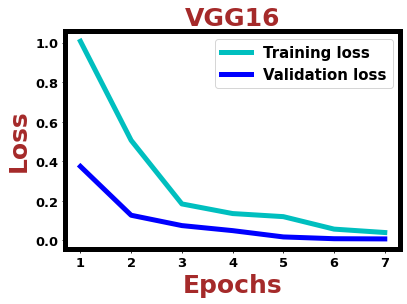

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

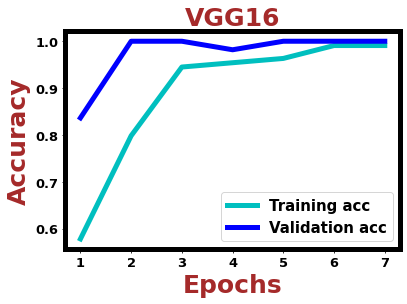

In [ ]:
# Plot the training and validation accuracy and loss at each epoch
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure()
ax = fig.add_subplot(111)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'c', label='Training loss',linewidth=5)
#y
plt.plot(epochs, val_loss, 'b', label='Validation loss',linewidth=5)
#r
for axis in ['top', 'bottom', 'left', 'right']:
  ax.spines[axis].set_linewidth(5)
plt.xticks(fontsize=13,weight='bold')
plt.yticks(fontsize=13,weight='bold')
plt.title('VGG16',fontsize=25,color='brown',weight='bold')
plt.xlabel('Epochs',fontsize=25,color='brown',weight='bold')
plt.ylabel('Loss',fontsize=25,color='brown',weight='bold')
plt.legend(prop={'size':15,'weight':'bold'})
plt.savefig("Loss_VGG16.pdf", bbox_inches='tight')
#plt.yticks(np.linspace(0.60,0.75,5))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
files.download("Loss_VGG16.pdf")
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'c', label='Training acc',linewidth=5)
plt.plot(epochs, val_acc, 'b', label='Validation acc',linewidth=5)
for axis in ['top', 'bottom', 'left', 'right']:
  ax.spines[axis].set_linewidth(5)
plt.xticks(fontsize=13,weight='bold')
plt.yticks(fontsize=13,weight='bold')
plt.title('VGG16',fontsize=25,color='brown',weight='bold')
plt.xlabel('Epochs',fontsize=25,color='brown',weight='bold')
plt.ylabel('Accuracy',fontsize=25,color='brown',weight='bold')
#plt.yticks(np.linspace(0.60,0.80,5))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend(prop={'size':15,'weight':'bold'})
plt.savefig("Acc_VGG16.pdf", bbox_inches='tight')
files.download("Acc_VGG16.pdf")
plt.show()

Accuracy =  1.0


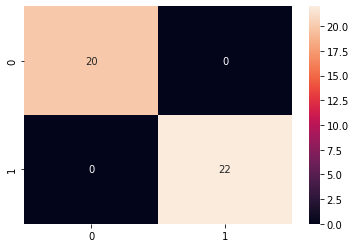

In [ ]:
#Print overall accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
x_out_Test = cnn_model_01.predict(x_test)
y_out_Test = cnn_model_02.predict(x_test)
prediction_NN = cnn_model.predict([x_out_Test, y_out_Test])
prediction_NN_ROC = prediction_NN                      # For plotting ROC curves
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_NN)
sns.heatmap(cm, annot=True)
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_NN))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

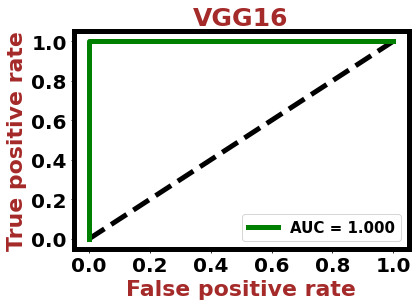

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_keras = prediction_NN_ROC.ravel()
le.fit(y_test)
y_test_temp = le.transform(y_test)
y_test_temp = to_categorical(y_test_temp)
y_test_keras = y_test_temp.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_keras, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
fig = plt.figure(1)
ax = fig.add_subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
  ax.spines[axis].set_linewidth(5)
plt.plot([0, 1], [0, 1], 'k--',linewidth=5)
plt.plot(fpr_keras, tpr_keras, 'g', label='AUC = {:.3f}'.format(auc_keras),linewidth=5)
plt.xticks(fontsize=20,weight='bold')
plt.yticks(fontsize=20,weight='bold')
plt.xlabel('False positive rate',fontsize=22,color='brown',weight='bold')
plt.ylabel('True positive rate',fontsize=22,color='brown',weight='bold')
plt.title('VGG16',fontsize=25,color='brown',weight='bold')
plt.legend(loc='best', prop={'size':15,'weight':'bold'})
plt.savefig("ROC_VGG16.pdf", bbox_inches='tight')
files.download("ROC_VGG16.pdf")
plt.show()

(1, 128, 128, 3)
The prediction for this image is:  ['Smoke']
The actual label for this image is:  Smoke


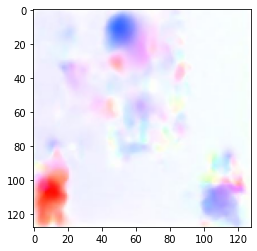

In [ ]:
#Check results on a few select images
n=14 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print(input_img.shape)
x_prediction = cnn_model_01.predict(input_img)
y_prediction = cnn_model_02.predict(input_img)
prediction = np.argmax(cnn_model.predict([x_prediction, y_prediction]))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", y_test[n])